# RBF Networks with Iris Data: Soup to Nuts (and Beyond!)


Review from Monday:

Training a RBF consists of:
* Finding prototypes
* Selecting the activation function for the hidden nodes
  * Any radial basis function will do; we use a Gaussian, $exp \left( - \frac{||\vec{d}-\vec{\mu_j}||^2}{2\sigma_j^2 + \epsilon} \right)$, where $\vec{d}$ is the data point, $\vec{\mu_j}$ is the prototype, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small constant and $||.||^2$ is the squared Euclidean distance. We calculate $\sigma_j$ as $\sigma_j = \frac{1}{N_j} \sum_{i=1}^{N_j} \sqrt{({d_j}_i - \mu_j)^2}$
where $N_j$ is the number of training points in the $j$th cluster, ${d_j}_i$ is the ith training data point in the $j$th cluster and $\mu_j$ is the prototype (centroid) associated with the $j$th cluster.
* Selecting the activation function for the output nodes
  * We use a simple weighted sum of the activations of the hidden nodes
* Setting the weights for the edges and biases

We use:
* kmeans to find prototypes
* linear regression to fit the edge weights from the hidden layer to the output layer

We can use RBF networks for:
* classification - by taking the absolute rounded value of the argmax of the outputs from the output layer (one output node per class)
* regression - by taking the output from the one node in the output layer

Today we will talk about:
* Visualizing neural networks and the activations of a neural network layer
* Hebbian learning - using RBF networks for clustering

As a sanity check when building a model, I suggest you *always print the shape at each step*.

## Load the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def type_converter(x):
    values = ['setosa', 'versicolor', 'virginica']
    return float(values.index(x))

def inverse_type_converter(x):
    values = ['setosa', 'versicolor', 'virginica']
    return values[x]


columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris = np.array(np.genfromtxt('data/iris.csv', delimiter=',', converters={4: type_converter}, skip_header=2, dtype=float, encoding='utf-8'))
print(iris.shape, iris.dtype)

(150, 5) float64


# Look at the Data

          0         1         2         3         4
0  7.900000  4.400000  6.900000  2.500000  2.000000
1  4.300000  2.000000  1.000000  0.100000  0.000000
2  5.843333  3.057333  3.758000  1.199333  1.000000
3  0.681122  0.188713  3.095503  0.577133  0.666667


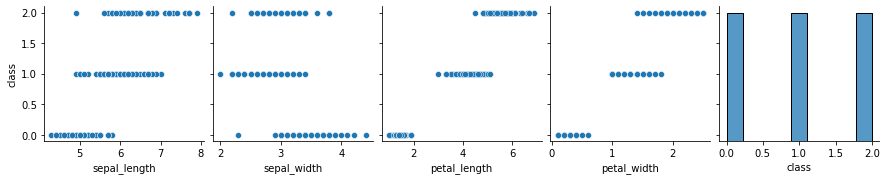

In [2]:
def get_summary_statistics(data):
    "Get the max, min, mean, var for each variable in the data."
    return pd.DataFrame(np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0), data.var(axis=0)]))

print(get_summary_statistics(iris))

df = pd.DataFrame(iris, columns=columns)
sns.pairplot(df, y_vars = ["class"], kind = "scatter")

## Clean the Data

Nothing to see here for the iris data

## Split the Data 

Into train, dev, test

In [3]:
# Why are we doing this?
np.random.shuffle(iris)

train_data, dev_data, test_data = np.split(iris, [int(.8 * len(iris)), int(.9 * len(iris))])
print("training data", "\n", train_data.shape, "\n", get_summary_statistics(train_data))
print("dev data", "\n", dev_data.shape, "\n", get_summary_statistics(dev_data))
print("test data", "\n", test_data.shape, "\n", get_summary_statistics(test_data))

training data 
 (120, 5) 
           0         1         2         3         4
0  7.900000  4.400000  6.900000  2.500000  2.000000
1  4.300000  2.000000  1.000000  0.100000  0.000000
2  5.855833  3.068333  3.820833  1.234167  1.033333
3  0.725133  0.206331  3.159983  0.595249  0.682222
dev data 
 (15, 5) 
           0         1         2         3         4
0  7.600000  3.800000  6.600000  2.100000  2.000000
1  4.700000  2.800000  1.300000  0.100000  0.000000
2  5.580000  3.166667  3.026667  0.913333  0.666667
3  0.688267  0.076889  3.287289  0.575822  0.622222
test data 
 (15, 5) 
           0         1         2         3         4
0  7.100000  3.500000  5.900000  2.100000  2.000000
1  5.000000  2.200000  1.300000  0.200000  0.000000
2  6.006667  2.860000  3.986667  1.206667  1.066667
3  0.224622  0.107733  1.769156  0.341956  0.462222


## Split off the Dependent Variable

In [4]:
dep_var = 4
ind_vars = list(range(train_data.shape[1]))
ind_vars.pop(dep_var)
dep_name = columns.pop(dep_var)
print(dep_var, ind_vars)

train_data, train_y = train_data[np.ix_(np.arange(train_data.shape[0]), ind_vars)], train_data[:, dep_var]
dev_data, dev_y = dev_data[np.ix_(np.arange(dev_data.shape[0]), ind_vars)], dev_data[:, dep_var]
test_data, test_y = test_data[np.ix_(np.arange(test_data.shape[0]), ind_vars)], test_data[:, dep_var]
print("training data", "\n", train_data.shape, "\n", get_summary_statistics(train_data))
print("dev data", "\n", dev_data.shape, "\n", get_summary_statistics(dev_data))
print("test data", "\n", test_data.shape, "\n", get_summary_statistics(test_data))

4 [0, 1, 2, 3]
training data 
 (120, 4) 
           0         1         2         3
0  7.900000  4.400000  6.900000  2.500000
1  4.300000  2.000000  1.000000  0.100000
2  5.855833  3.068333  3.820833  1.234167
3  0.725133  0.206331  3.159983  0.595249
dev data 
 (15, 4) 
           0         1         2         3
0  7.600000  3.800000  6.600000  2.100000
1  4.700000  2.800000  1.300000  0.100000
2  5.580000  3.166667  3.026667  0.913333
3  0.688267  0.076889  3.287289  0.575822
test data 
 (15, 4) 
           0         1         2         3
0  7.100000  3.500000  5.900000  2.100000
1  5.000000  2.200000  1.300000  0.200000
2  6.006667  2.860000  3.986667  1.206667
3  0.224622  0.107733  1.769156  0.341956


## Consider Transforming/Normalizing the Data

In [5]:
def homogenizeData(data):
    return np.append(data, np.array([np.ones(data.shape[0], dtype=float)]).T, axis=1)
   
def zScore(data, translateTransform=None, scaleTransform=None):
    "z score."
    homogenizedData = np.append(data, np.array([np.ones(data.shape[0], dtype=float)]).T, axis=1)
    if translateTransform is None:
        translateTransform = np.eye(homogenizedData.shape[1])
        for i in range(homogenizedData.shape[1]):
            translateTransform[i, homogenizedData.shape[1]-1] = -homogenizedData[:, i].mean()
    if scaleTransform is None:
        diagonal = [1 / homogenizedData[:, i].std() if homogenizedData[:, i].std() != 0 else 1 for i in range(homogenizedData.shape[1])]
        scaleTransform = np.eye(homogenizedData.shape[1], dtype=float) * diagonal
    data = (scaleTransform@translateTransform@homogenizedData.T).T
    return translateTransform, scaleTransform, data[:, :data.shape[1]-1]

translateTransform, scaleTransform, train_data_transformed = zScore(train_data)
print("training data", "\n", train_data_transformed.shape, "\n", get_summary_statistics(train_data_transformed))

_, _, dev_data_transformed = zScore(dev_data, translateTransform=translateTransform, scaleTransform=scaleTransform)
print("dev data", "\n", dev_data_transformed.shape, "\n", get_summary_statistics(dev_data_transformed))

_, _, test_data_transformed = zScore(test_data, translateTransform=translateTransform, scaleTransform=scaleTransform)
print("test data", "\n", test_data_transformed.shape, "\n", get_summary_statistics(test_data_transformed))

training data 
 (120, 4) 
               0             1             2             3
0  2.400532e+00  2.931661e+00  1.732171e+00  1.640692e+00
1 -1.827066e+00 -2.351933e+00 -1.586847e+00 -1.470034e+00
2 -4.884981e-16 -4.440892e-17 -8.511710e-17 -4.440892e-17
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
dev data 
 (15, 4) 
           0         1         2         3
0  2.048233  1.610762  1.563408  1.122238
1 -1.357333 -0.590735 -1.418083 -1.470034
2 -0.323920  0.216481 -0.446755 -0.415844
3  0.949160  0.372649  1.040287  0.967363
test data 
 (15, 4) 
           0         1         2         3
0  1.461066  0.950313  1.169626  1.122238
1 -1.005033 -1.911634 -1.418083 -1.340421
2  0.177129 -0.458645  0.093289 -0.035644
3  0.309767  0.522140  0.559862  0.574475


## Consider Dimensionality Reduction

Nothing to see here for the iris data

# Find Prototypes

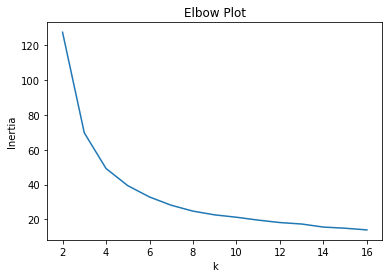

In [6]:
from sklearn.cluster import KMeans

inertia_by_k = []

for k in range(2, 17):
    km = KMeans(n_clusters=k, random_state=0).fit(train_data)
    inertia_by_k.append([k, km.inertia_])

inertia_by_k = np.array(inertia_by_k)
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.plot(inertia_by_k[:, 0], inertia_by_k[:, 1])
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Plot')
plt.show()

In [7]:
k = 11

km = KMeans(n_clusters=k, random_state=0).fit(train_data)

print(km.cluster_centers_.shape)

(11, 4)


# Define the Activation Function for the Hidden Nodes

In [8]:
# I am going to implement a _stupid activation function_ so that you can implement the right one yourselves for project 7
def calculate_activations(data, centroids):
    "I repeat, do not use this activation function directly. This one is exp(-distance / 3); yours is exp(-distance^2 / (2*radius + epsilon))"
    # You can easily fiddle with this numerator to make it calculate the square of the distance
    numerator = -np.linalg.norm(data-centroids[:,np.newaxis], axis = 2).T
    # The construction of your denominator will be a little more complex than this; the diagonals will be centroid/prototype-specific
    denominator = np.eye(centroids.shape[0], dtype=float) * 1/3
    print(numerator.shape, denominator.shape)
    return np.exp((denominator@numerator.T).T)

train_calcs = calculate_activations(train_data_transformed, km.cluster_centers_)
print(train_calcs.shape)

(120, 11) (11, 11)
(120, 11)


# Define the Activation Function for the Output Nodes

In a RBF network, this will be a straight linear function.

# Calculate the Values for the Weights on the Edges to the Output Nodes

In [9]:
from sklearn.linear_model import LinearRegression

def fit_classification(A, y):
    all_ys = []
    for value in np.unique(y):
        all_ys.append([1 if x == value else 0 for x in train_y])
    y = np.vstack(all_ys).T
    reg = LinearRegression().fit(A, y)
    print("coefficients", "\n", reg.coef_.shape)
    print("intercepts", "\n", reg.intercept_.shape)
    return reg

def fit_regression(A, y):
    reg = LinearRegression().fit(A, y)
    print("coefficients", "\n", reg.coef_.shape)
    print("intercepts", "\n", reg.intercept_.shape)
    return reg

if dep_var == 4:
    reg = fit_classification(train_calcs, train_y)
else:
    reg = fit_regression(train_calcs, train_y)

coefficients 
 (3, 11)
intercepts 
 (3,)


# Test and Score

In [10]:
dev_calcs = calculate_activations(dev_data_transformed, km.cluster_centers_)
print(dev_calcs.shape)

dev_yhat = reg.predict(dev_calcs)
print(dev_yhat.shape)
print(dev_yhat)

(15, 11) (11, 11)
(15, 11)
(15, 3)
[[-0.12584556  0.23204325  0.89380231]
 [ 0.82360156  0.27081744 -0.094419  ]
 [ 0.13549945  0.48686232  0.37763823]
 [ 0.84830839  0.21856635 -0.06687474]
 [ 0.17818617  0.61860663  0.2032072 ]
 [ 0.9418113   0.19060574 -0.13241704]
 [ 1.02245243  0.08940838 -0.11186081]
 [ 0.82502245  0.32069837 -0.14572082]
 [ 0.31510149  0.5316872   0.15321131]
 [ 0.90259529  0.20654466 -0.10913995]
 [ 0.88364648  0.18309963 -0.06674611]
 [-0.12333053  0.31837616  0.80495437]
 [ 0.22799045  0.57644956  0.19555999]
 [ 0.3018814  -0.82980735  1.52792595]
 [ 0.99194995 -0.00518186  0.01323192]]


In [11]:
def final_prediction(input_predictions):
    return np.argmax(input_predictions)

if dep_var == 4:
    dev_yhat = [final_prediction(dev_yhat[i]) for i in range(dev_yhat.shape[0])]
print(dev_yhat)
print(dev_y)

[2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 0]
[2. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 2. 1. 2. 0.]


In [12]:
def accuracy(y, yhat):
    return np.sum([1 if y[i]==yhat[i] else 0 for i in range(len(y))]) / len(y)

def rsquared(y, yhat):
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())
 
if dep_var == 4:
    print(accuracy(dev_y, dev_yhat))
else:
    print(rsquared(dev_y, dev_yhat))

1.0


# Visualizing Neural Networks

## Visualize the network itself

For this, there are many options. We will use *graphviz*. To install graphviz:
* First, download and stall the appropriate executable package from https://www.graphviz.org/download/ (for Windows or Mac)
* Then, do pip install graphviz or (or conda install graphviz) to install the python bindings
You may have to restart your computer after this for the computer to find the paths.

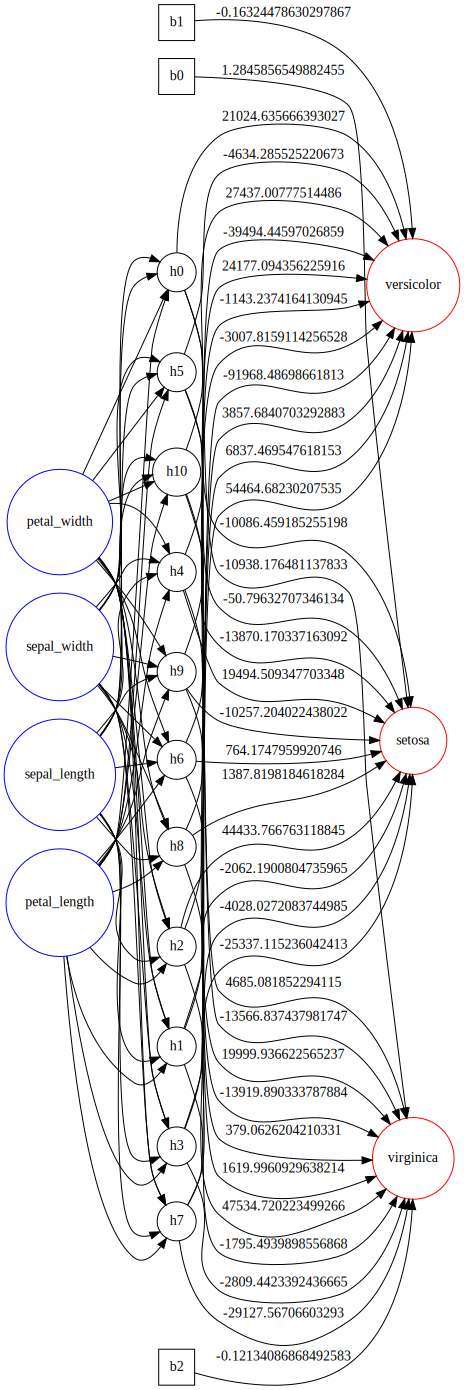

In [13]:
from graphviz import Digraph

# Let's make a graph
network = Digraph(format='png', comment='RBF network')
# Let's make it draw from left to right
network.attr(rankdir='LR')
# Let's make it draw straight lines for edges rather than curves
#network.attr(splines='line')

# Add input nodes
with network.subgraph(name='input', node_attr={'shape': 'circle', 'color': 'blue'}) as input:
    for i in range(len(columns)):
        input.node('i'+str(i), columns[i])

# Add hidden layer nodes
with network.subgraph(name='hidden', node_attr={'shape': 'circle', 'color': 'black'}) as hidden:
    for i in range(k):
        hidden.node('h'+str(i))

# Add bias nodes
o_len = 1
if len(reg.coef_.shape) > 1:
    o_len = reg.coef_.shape[0]
with network.subgraph(name='bias', node_attr={'shape': 'square', 'color': 'black'}) as bias:
    for i in range(o_len):
        bias.node('b'+str(i))

# Add output layer nodes
with network.subgraph(name='output', node_attr={'shape': 'circle', 'color': 'red'}) as output:
    for i in range(o_len):
        output.node('o'+ str(i), inverse_type_converter(i))


# Add edges from input to hidden layer
for i in range(len(columns)):
    for j in range(k):
        network.edge('i'+ str(i), 'h'+str(j))

# Add edges from hidden to output layer
for i in range(k):
    for j in range(o_len):
        network.edge('h'+str(i), 'o'+str(j), label=str(reg.coef_[j, i]))

# Add edges from bias to output layer
for i in range(o_len):
    network.edge('b'+str(i), 'o'+str(i), label=str(reg.intercept_[i]))

network

# Visualizing the *activation* of one or more layers of the network for an input

One way to do this is with a heatmap.

<AxesSubplot:>

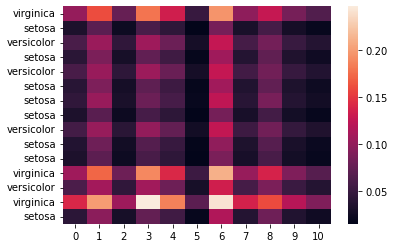

In [14]:
sns.heatmap(dev_calcs , yticklabels=[inverse_type_converter(int(x)) for x in dev_y])